# Circuit implementation of quantum teleportation using Qiskit

This notebook will teach you how to construct your own circuits for a quantum teleportation protocol using Qiskit.

# Install Qiskit

Install Qiskit if you haven't. Here we are not installing the latest version of Qiskit since it has an issue with displaying circuits using matplotlib (fancy circuits) in Colab.

In [ ]:
!pip install qiskit==0.16.1

# Importing Packages

In [ ]:
from qiskit import * # No need to explain why
import matplotlib as mpl # Required to display some fancy circuits
import numpy as np # Required to prepare and play around with the state to be teleported

# The circuit

Now, we move on to main part of the notebook. In this section, we shall explain the construction of the circuit for implementing a quantum teleportation protocol. The procedure enables Alice to send (teleport) an arbitray qubit worth information to Bob, without knowing what the state pertaining to that qubit is. The protocol is as follows:

1. Alice, has in her possession, a qubit $q$ with the state $|\psi \rangle$ prepared in it.

2. Alice and Bob has to be sharing a Bell state $|\beta\rangle = \frac{1}{\sqrt{2}}\Big( |00\rangle + |11\rangle\Big)$ among them, that is, one qubit $q_A$ in this state should be with Alice, and the other qubit $q_B$ should be with Bob.

3. Alice applies a $CNOT$ gate, controlled on $q$ and targetted on $q_A$. Then she applies a Hadamard gate on $q$. 

5. Then, Alice measures both qubits in her possession. The output of the measurement is conveyed to Bob through a classical channel. 

6. After measurement, if $q_A$ resulted in $1$, Bob applies an $X$ gate on the qubit in his possession, $q_B$. Then, if $q$ resulted in $1$, Bob applies a $Z$ gate on $q_B$. At this point, we have the qubit $q_B$ having the state $|\psi \rangle$.

Hence, the circuit that we are going to implemented would look like this

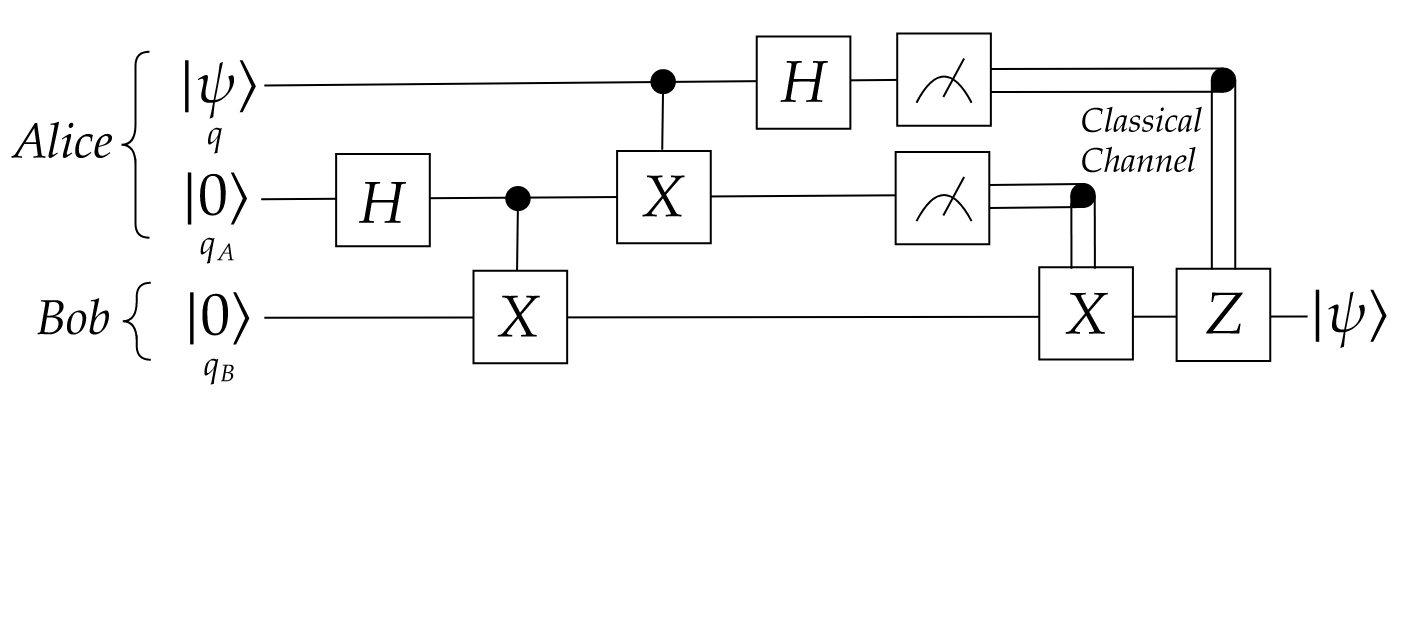

# Implementation of Quantum Teleportation

Now, we move on to constructing this circuit using Qiskit

Lets start by generating an arbitrary normalized complex vector in two dimensions.


In [ ]:
# Prepare a random complex vector in 2 dimensions
psi = np.random.random(2) + (1j * np.random.random(2))
psi = psi/np.linalg.norm(psi)
print(psi)

[0.29963573+0.36839729j 0.07573807+0.8767928j ]


This is our state $|\psi\rangle$. In the first part of this section, we'll prepare the state $| \psi \rangle$ in the first register and then see how the state looks like in Qiskit. For that, we initialize a quantum register of 3 qubits.

In [ ]:
# Prepare the quantum register
qr = QuantumRegister(3)

We now initialize a quantum circuit using this register.

In [ ]:
# Prepare the quantum circuit
qc = QuantumCircuit(qr)

Now we'll prepare $|\psi\rangle$ in the first qubit.

In [ ]:
# Initialze psi in qubit 0
qc.initialize(psi, 0)

Let's take a look at the state at this point.

In [ ]:
# Compute the state vector
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
statevector

array([0.29963573+0.36839729j, 0.07573807+0.8767928j ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ])

By converting each index of the vector into binary, this state can be viewed as 

In [ ]:
# This function converts a decimal number to its binary expansion
def Binary(x, BitNo):
  format(x, 'b').zfill(BitNo)
  Binlist = [int(y) for y in list(format(x, 'b').zfill(BitNo))]
  return Binlist

state_dict = {}
for i in range(8):
  bin_list = Binary(i,3)
  state_dict["".join(map(str, bin_list))] = statevector[i]

state_dict

{'000': (0.2996357304145474+0.36839728908109365j),
 '001': (0.07573807185797438+0.8767927981729082j),
 '010': 0j,
 '011': 0j,
 '100': 0j,
 '101': 0j,
 '110': 0j,
 '111': 0j}

Note that in Qiskit, the leftmost qubit is the most significant qubit. So, from the description of the state, we can see that $| \psi \rangle$ is indeed in the first qubit.

In the next part of the notebook, we shall carry out the quantum teleportation protocol. We start by initializing a quantum register of 3 qubits.

In [ ]:
# Prepare the quantum register
qr = QuantumRegister(3)

Next, we shall prepare the classical register which will have the classical output after measurement. Since the circuit only requires measuring two qubits, the classical register requires only 2 bits. So 

In [ ]:
# Prepare the classical register
cr_q = ClassicalRegister(1, name="cr_q")
cr_qA = ClassicalRegister(1, name="cr_qA")

Combining both the quantum and classical registers, we now define the quantum circuit

In [ ]:
# Prepare the quantum circuit
qc = QuantumCircuit(qr, cr_q, cr_qA)

We'll start by preparing $|\psi\rangle$ in the first qubit.

In [ ]:
# Initialze psi in qubit 0
qc.initialize(psi, 0)

Next step is to prepare $|\beta\rangle = \frac{1}{\sqrt{2}}\Big( |00\rangle + |11\rangle\Big)$ in the second and third qubit. This is done by applying an $H$ gate followed by a $CNOT$ gate.

In [ ]:
# Apply Hadamard gate on qubit 1 
qc.h(1)

# Apply CNOT gate on qubits 1 and 2
qc.cnot(1,2)

Now is the teleportation part. Alice applies a $CNOT$ gate on the first and second qubits. Then she applies an $H$ gate on the first qubit.

In [ ]:
# Apply CNOT gate on qubits 0 and 1 
qc.cnot(0,1)

# Apply Hadamard gate on qubit 0
qc.h(0)

Lets take a look at the circuit we have build so far

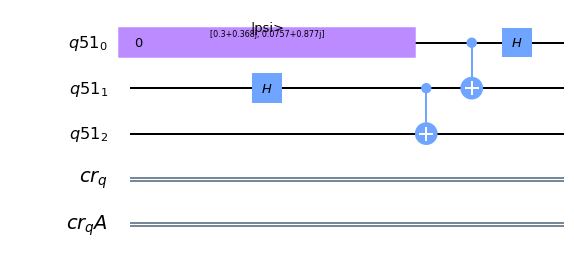

In [ ]:
# Display circuit
qc.draw(output = "mpl")

Seems to be correct.

Next, Alice measures the qubits in her possession.

In [ ]:
# Measure qubits 0,1
qc.measure(0, 0) # This output is stored in classical register cr_q
qc.measure(1, 1) # This output is stored in classical register cr_qA

Now, depending on the result of this measurement, Bob applies gates on the third qubit. If the measurement of the second qubit resulted in $1$, Bob applies an $X$ gate and then if the measurement of the first qubit resulted in $1$, he applies a $Z$ gate. 

In [ ]:
# Apply X gate on qubit 2 if cr_qA is 1
qc.x(2).c_if(cr_qA, 1)

# Apply Z gate on qubit 2 if cr_q is 1
qc.z(2).c_if(cr_q, 1)

Let's take a look at the final circuit

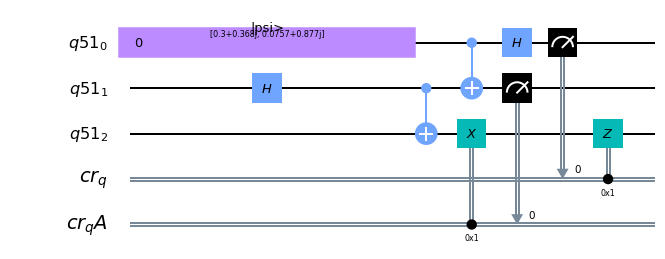

In [ ]:
# Display circuit
qc.draw(output = "mpl")

Now, let's take a sneak peak at the state

In [ ]:
# Compute the statevector
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
statevector

array([0.        +0.j        , 0.29963573+0.36839729j,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.07573807+0.8767928j ,
       0.        +0.j        , 0.        +0.j        ])

By converting each index of the vector into binary, this state can be viewed as 

In [ ]:
state_dict = {}
for i in range(8):
  bin_list = Binary(i,3)
  state_dict["".join(map(str, bin_list))] = statevector[i]

state_dict

{'000': 0j,
 '001': (0.2996357304145474+0.3683972890810936j),
 '010': 0j,
 '011': 0j,
 '100': 0j,
 '101': (0.07573807185797449+0.8767927981729082j),
 '110': 0j,
 '111': 0j}

From the output, we can see that the qubit has been teleported from the first qubit to the thrid qubit. Next step is to verify if we really did retreive $|\psi \rangle$ in the final qubit. For that, first we want to extract $|\psi\rangle$ from the output, and store it in an array named "quantum_output". Once that is done, we compute the fidelity between that and $|\psi \rangle$. That is, we compute

\begin{equation}
  \Big| \langle \text{quantum_output}|\psi \rangle\Big|
\end{equation}

and if this output is $1$, our circuit seems to be doing the job.

In [ ]:
# Extract the statevector
k = 0
quantum_output = np.zeros(2) + (1j * np.zeros(2))
for i in range(8):
  if np.abs(statevector[i]) > 0:
    quantum_output[k] = statevector[i]
    k += 1

# Display the fidelity
print("The fidelity is: {}".format(np.abs(np.dot(np.conj(quantum_output), psi))))

The fidelity is: 1.0


As expected, the fidelity is $1$. 

Now, let's run this teleportation scheme multiple times and observe the result. 

In [ ]:
for i in range(20):
  # Prepare the quantum register
  qr = QuantumRegister(3)

  # Prepare the classical register
  cr_q = ClassicalRegister(1, name="cr_a")
  cr_qA = ClassicalRegister(1, name="cr_aA")

  # Prepare the quantum circuit
  qc = QuantumCircuit(qr, cr_q, cr_qA)

  qc.initialize(psi, 0)

  # Apply Hadamard gate on qubit 1 
  qc.h(1)

  # Apply CNOT gate on qubits 1 and 2
  qc.cnot(1,2)

  # Apply CNOT gate on qubits 0 and 1 
  qc.cnot(0,1)

  # Apply Hadamard gate on qubit 0
  qc.h(0)

  # Measure qubits 0,1
  qc.measure(0, 0)
  qc.measure(1, 1)

  # Apply X gate on qubit 2 if the cr_qA is 1
  qc.x(2).c_if(cr_qA, 1)

  # Apply Z gate on qubit 2 if the cr_q is 1
  qc.z(2).c_if(cr_q, 1)

  # Extract the statevector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()

  # Extract the statevector
  k = 0
  quantum_output = np.zeros(2) + (1j * np.zeros(2))
  for i in range(8):
    if np.abs(statevector[i]) > 0:
      quantum_output[k] = statevector[i]
      k += 1

  # Display the fidelity
  print("The fidelity is: {}".format(np.abs(np.dot(np.conj(quantum_output), psi))))

The fidelity is: 1.0
The fidelity is: 1.0
The fidelity is: 1.0
The fidelity is: 1.0
The fidelity is: 1.0
The fidelity is: 0.9999999999999999
The fidelity is: 0.9999999999999999
The fidelity is: 1.0
The fidelity is: 0.9999999999999999
The fidelity is: 1.0
The fidelity is: 1.0
The fidelity is: 1.0
The fidelity is: 0.9999999999999999
The fidelity is: 0.9999999999999999
The fidelity is: 0.9999999999999999
The fidelity is: 0.9999999999999999
The fidelity is: 0.9999999999999999
The fidelity is: 0.9999999999999999
The fidelity is: 0.9999999999999999
The fidelity is: 1.0


As the result is 1 always, we can safely assume that our circuit is indeed a quantum teleportation protocol.